In [2]:
# Libraries
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/test.csv
/content/sample_submission.csv
/content/train.csv
/content/.config/active_config
/content/.config/config_sentinel
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/gce
/content/.config/configurations/config_default
/content/.config/logs/2021.03.25/13.38.09.835215.log
/content/.config/logs/2021.03.25/13.38.26.474054.log
/content/.config/logs/2021.03.25/13.38.27.034051.log
/content/.config/logs/2021.03.25/13.38.04.266969.log
/content/.config/logs/2021.03.25/13.37.29.839683.log
/content/.config/logs/2021.03.25/13.37.48.611688.log
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv


# Time Series Using LightGBM with Explanations

In this notebook I will be working with Kaggle's [Store Item Demand Forecasting Challange](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) dataset in order to deep dive into Time Series Analysis.

While exploring in the past in order to find clues for the future, I will be explaining the whole process step by step and also sharing useful theoretical informations that is needed in order to understand the nature of Time Series.

# Table of Content

1. [Introduction](#section-intro)
2. [What is Time Series](#section-ts)
3. [ML Project](#section-pro)
    * 3.1.[Import Library and Load Dataset](#section-one)
    * 3.2.[Exploratory Data Analysis](#section-two)
    * 3.3.[Outlier Check](#section-three)    
    * 3.4.[Time Series Decomposition](#section-four)
    * 3.5.[Feature Engineering](#section-five)
        * 3.5.1.[Random Noise](#section-six)  
        * 3.5.2.[Lag/Shifted Features](#section-seven)
        * 3.5.3.[Rolling Mean/Moving Average](#section-eight)
        * 3.5.4.[Exponentially Weighted Mean Features](#section-nine)
    * 3.6.[One Hot Encoding](#section-ten)
    * 3.7.[Custom Cost Function](#section-eleven)
    * 3.8.[Train-Validation Split](#section-twelve) 
    * 3.9.[Base Model](#section-thirteen)
    * 3.10.[Final Model](#section-fourteen)
    * 3.11.[Submit Prediction](#section-fifteen)

<a id="section-intro"></a>
# 1.Introduction

## Overview of the Dataset  

Train dataset contains 5 years of sales data per 50 different items being sold in 10 different stores. It covers the period between 2013-01-01 and 2017-12-31. 

We are expected to forecast the daily sales of each item in each store for the time interval of 2018-01-01 and 2018-03-31. I will use LightGBM where I will benefit from early stopping interval in order to avoid overfitting.

<a id="section-ts"></a>
# 2.What is Time Series?

Time series is a sequence of observations recorded at regular time intervals. It is composed of discrete-time periods that are ordered succesively. When each value of the time points are concatenated, these independent points will form a non-discrete data, reveal the correlations and by using this data it would be possible to have a prediction of what would be coming next. 

Time Series are mostly used for:

* monitor sensor data
* track assets (such as cars of a fleet, items in a store)
* business forecasting
* understand past behaviours (of customers, stocks, etc.)
* predict and plan future
* evaluate current accomplishment

<a id="section-pro"></a>
# 3.ML Project

<a id="section-one"></a>
## 3.1.Import Library

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Dataset

In [4]:
# Train and test datasets are being concatenated, because I will need the past in order to predict the future based on 
# some possible patterns that occured in the past.

train = pd.read_csv("/content/train.csv", parse_dates=['date'])
test = pd.read_csv("/content/test.csv", parse_dates=['date'])
df = pd.concat([train, test], sort=False)

<a id="section-two"></a>
# 3.2.Exploratory Data Analysis

In [5]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
##################### Tail #####################
             date  store  item  sales
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item    1.0   3.0  25.5   48.0   50.0   50.0
sales   0.0  16.0  47.0  107.0  135.0  231.0


Train dataset has 4 variables : store, item, sales (target variable) and date. Date is the variable with which I will derive features to use for my ML model. This is why I parsed the date variable while reading csv.

Train dataset covers the period between 2013-01-01 and 2017-12-31, so it's 5 years' time.

There are no missing values, I'll check sales for outliers.

In [6]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
##################### Tail #####################
          id       date  store  item
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64
##################### Quantiles #####################
       0.00     0.05     0.50      0.95      0.99     1.00
id      0.0  2249.95  22499.5  42749.05  44549.01  44999.0
store   1.0     1.00      5.5     10.00     10.00     10.0
item    1.0     3.00     25.5     48.00     50.00     50.0


Test dataset has 4 variables : id (which I'll need when submitting predicted sales values), store, item and date. There is no sales variable in test dataset for this is the variable that I will be predicting.

Test dataset covers the period between 2018-01-01 and 2018-03-31, so I will be predicting 3 months of sales per each store and item per each day.

There are no missing values.


<a id="section-three"></a>
## 3.3.Outlier Check  

Time for an outlier check!

For outlier detection, I will use IQR method with Q1 as 0.05% and Q3 as 0.95%. I will compute the low limit and up limit with IQR method and check if the sales variable contain values above/below these limits. It will return boolean.



In [9]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [10]:
check_outlier(df, 'sales')

False

no outliers for sales variable.

In [11]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [12]:
df.tail()

,date,store,item,sales,id
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0
44999,2018-03-31,10,50,NaN,44999.0


id values are only present in test dataset whereas sales variables are only present in train dataset. 

The reason for concatenating the train and test dataset is to gain insight and find patterns from the previous sales values and finally be able to have a better prediction.

In [15]:
print(f"total number of stores: {df['store'].nunique()}")
print(f"total number of items: {df['item'].nunique()}")
print(f"total number of items per each store: {df.groupby(['store'])['item'].nunique()}")

total number of stores: 10
total number of items: 50
total number of items per each store: store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


In [17]:
df.groupby(["item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
            sum       mean median        std
item                                        
1      401384.0  21.981599   21.0   8.468922
2     1069564.0  58.574151   56.0  20.093015
3      669087.0  36.642223   35.0  13.179441
4      401907.0  22.010241   21.0   8.403898
5      335230.0  18.358708   18.0   7.265167
6     1068281.0  58.503888   56.0  20.174898
7     1068777.0  58.531051   56.0  20.146002
8     1405108.0  76.950055   74.0  26.130697
9      938379.0  51.389869   49.5  17.790158
10    1337133.0  73.227437   70.0  24.823725
11    1271925.0  69.656353   67.0  23.744732
12    1271534.0  69.634940   67.0  23.738663
13    1539621.0  84.316594   81.0  28.311031
14    1071531.0  58.681873   56.0  20.079860
15    1607442.0  88.030778   85.0  29.522852
16     468480.0  25.656079   25.0   9.603270
17     602486.0  32.994852   32.0  11.967610
18    1538876.0  84.275794   81.0  28.430621
19     736892.0  40.355531   39.0  14.332645
20     867641.0  47.515936   46.0  16.490487
21     736190.0  40.317087   39.0  14.338006
22    1469971.0  80.502245   78.0  27.118163
23     534979.0  29.297864   28.0  10.819549
24    1205975.0  66.044633   64.0  22.531555
25    1473334.0  80.686418   78.0  27.238817
26     869981.0  47.644085   46.0  16.723912
27     402628.0  22.049726   21.0   8.461641
28    1604713.0  87.881325   85.0  29.501781
29    1271240.0  69.618839   67.0  23.635631
30     736554.0  40.337021   39.0  14.363331
31    1070845.0  58.644304   57.0  20.104705
32     803107.0  43.981763   42.0  15.574556
33    1270183.0  69.560953   67.0  23.718343
34     469935.0  25.735761   25.0   9.617910
35    1201541.0  65.801807   63.0  22.461990
36    1406548.0  77.028916   74.0  26.067440
37     534258.0  29.258379   28.0  10.771547
38    1470330.0  80.521906   77.0  27.141799
39     801311.0  43.883406   42.0  15.511550
40     534094.0  29.249398   28.0  10.822959
41     401759.0  22.002136   21.0   8.402470
42     669925.0  36.688116   35.0  13.215112
43     936635.0  51.294359   49.0  17.801008
44     536811.0  29.398193   28.0  10.797738
45    1471467.0  80.584173   78.0  27.318402
46    1070764.0  58.639869   56.0  20.220879
47     401781.0  22.003341   21.0   8.420102
48     937703.0  51.352848   49.0  17.881917
49     535663.0  29.335323   28.0  10.874788
50    1203009.0  65.882202   63.0  22.416031

<Figure size 432x288 with 0 Axes>

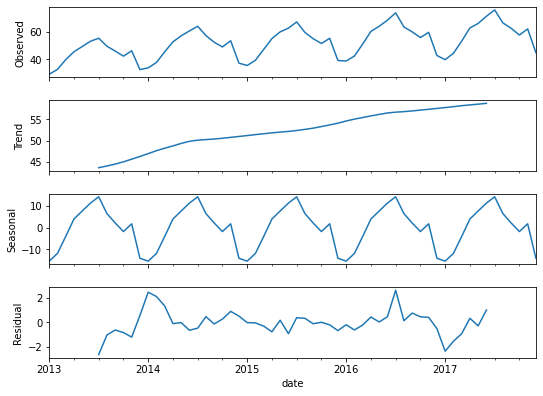

In [25]:
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive') # Usage of Statistical Models
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

based on the:

* 1st graph: the dataset is not stationary, it would be easier to have a future prediction simply by taking mean values if it was stationary,
* 2nd graph: there is an increasing trend over time,
* 3rd graph: a repeating pattern is observed, so there is seasonality- moving upwards on July.
* 4th graph: residuals are decomposing randomly around 0, so the series is additive.

<a id="section-five"></a>
# 3.5.Feature Engineering

In order to search for seasonalities, date variable will be used to derive new features and different time periods will be created.

In [26]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [27]:
df = create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0


<a id="section-six"></a>
## 3.5.1.Random Noise

For small datasets like this one, in order to avoid overfitting, random noise can be added to the values. I will add Gaussian random noise which is normally distributed with a standard deviation of 1 and mean of 0.

In [28]:
def random_noise(dataframe):
  return np.random.normal(size=(len(dataframe),))
  #In Order to Avoid Overfitting of the model

<a id="section-seven"></a>
## 3.5.2.Lag/Shifted Features 

Time Series theory states that, the value in time: t highly depends on the value in time: t-1. That is why I will be shifting all the sales values by 1 and adding noise.

In [29]:
# sort the values per store, item and date so that values would be shifted equally
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [31]:
# the feature name will be created dynamically with regards to the lag value for a given list of lags
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [32]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

<a id="section-eight"></a>
## 3.5.3.Rolling Mean / Moving Average  

In order to find out possible seasonalities, I will be creating moving averagesfor specified time intervals. This function takes the number of time given as window parameter and takes the average of the values, but one of the values is the value on this specific observation. In order to eliminate today's affect on moving average values, I will take 1 shift and use this function

In [36]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [37]:
df = roll_mean_features(df, [365, 546, 730])
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The values for the newly derived lag and rolling mean features will be NaN for most of the train part of the dataframe. This is normal as we are trying to find patterns in order to be able to predict the values in test dataset.

<a id="section-nine"></a>
## 3.5.4.Exponentially Weighted Mean Features  

The value in time t highly depends on the value in time t-1, so in order to have a better prediction, while computing the average value, the values should not be equally weighted.

In [38]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In this function, values will be shifted by the given lags (number of days to be used for calculation) and the values will be weighted (using the alpha value) and the mean weighted value is obtained.
Alpha is a parameter that is between 0 and 1, when close to 1 the near past will be weighted more and oppositely when close to 0 the far past will be weighted more.

In [39]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [40]:
df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,2018,0,0,0,41.075313,52.879479,66.462273,68.549745,67.963271,80.980415,78.996229,60.120380,98.069577,72.404707,88.801625,85.260011,82.585342,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,2018,0,0,0,65.198191,50.764235,66.656734,61.110777,76.480864,81.406536,78.896196,73.044706,81.545567,67.758608,88.452685,85.595824,81.543737,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,2018,0,0,0,61.251978,60.604652,72.229030,64.217129,72.321187,85.813036,82.010079,67.971180,97.791378,74.192596,88.234472,84.911291,82.472102,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,2018,1,0,0,74.157642,73.732775,72.876676,65.606493,66.231807,81.456136,88.558546,69.648581,79.882142,83.962295,87.184589,85.136766,81.356587,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.6024

## Taking Log Values of Sales  

In regression problems using gradient descent optimisation, when the target value is higher, the number of iterations would decrease and so the computation time. In order to eliminate this problem, I will be taking the logaritmic values of the target value. 

In [64]:
df['sales'] = np.log1p(df["sales"].values)
df['sales'].head() 

0    1.291725
1    1.248441
2    1.310506
3    1.291725
4    1.223156
Name: sales, dtype: float64

<a id="section-eleven"></a>
## 3.7.Custom Cost Function 

I will define a custom cost function which is based on SMAPE which reverses the log values and calculates the SMAPE.

In [65]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

**SMAPE**:  

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. Errors with higher values will be adjusted by diving it to the sum of the forecast and actual value's average.


<a id="section-twelve"></a>
##  3.8.Train-Validation Split

Validation will be the exact same time period as test, but the year before. 

In [66]:
train = df.loc[(df["date"] < "2017-01-01"), :]
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

In [67]:
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [68]:
# columns with no useful information or with information that is already derived will be dropped.

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [70]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

If the model begins to memorize the train dataset instead of learning it, the error will get lower but the model won't be able to have a good prediction of the validation set (because it didn't learn the patterns) so the error in validation will begin to increase.

In the below graphic, as variance increase, the errors in both train and dataset decrease until they reach to a certain point where the test errors no longer decrease but train errors are still decreasing. This is the point where overfitting begins. This is the point where the iteration process should be interrupted. This will be handled by a special hyperparameter within LightGBM.

early_stopping_rounds wil be given as a hyperparameter. In the specified time intervals, the iteration will be paused and the l1 and SMAPE of train and validation set will be calculated, at the point where the validation error will begin to increase while train error is still decreasing, the iteration process will be interrupted.

<a id="section-thirteen"></a>
## 3.9.Base Model

In [71]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [72]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [73]:
# lgbtrain and lgbval's datatype is LightGBM Dataset

type(lgbtrain)

lightgbm.basic.Dataset

In [74]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 0.0308579	training's SMAPE: 3.97236	valid_1's l1: 0.0319307	valid_1's SMAPE: 4.12844
[400]	training's l1: 0.0292386	training's SMAPE: 3.7685	valid_1's l1: 0.0307062	valid_1's SMAPE: 3.96975
[600]	training's l1: 0.028768	training's SMAPE: 3.7091	valid_1's l1: 0.0302632	valid_1's SMAPE: 3.91375
[800]	training's l1: 0.0285119	training's SMAPE: 3.67667	valid_1's l1: 0.0299852	valid_1's SMAPE: 3.87868
[1000]	training's l1: 0.0283323	training's SMAPE: 3.65388	valid_1's l1: 0.0298253	valid_1's SMAPE: 3.8585
[1200]	training's l1: 0.0282043	training's SMAPE: 3.63761	valid_1's l1: 0.0297448	valid_1's SMAPE: 3.84826
[1400]	training's l1: 0.0281052	training's SMAPE: 3.62499	valid_1's l1: 0.0296857	valid_1's SMAPE: 3.84072
[1600]	training's l1: 0.0280284	training's SMAPE: 3.61522	valid_1's l1: 0.0296253	valid_1's SMAPE: 3.83313
[1800]	training's l1: 0.0279659	training's SMAPE: 3.60724	valid_1's l1: 0.0295758	valid_1

In [75]:
# sales values in train dataset will be predicted, these are the log values

y_pred_val = model.predict(X_val)

In [76]:
# log values are reversed and the predicted sales values are revealed. 

smape(np.expm1(y_pred_val), np.expm1(Y_val))

3.7827392805059765

**Feature Importances**:

These will be calculated based on split and gain values, that is how often they have been used for splitting the values and the gain of entropy.

In [77]:
def plot_lgb_importances(model,plot=True,num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    print(feat_imp.head(num))

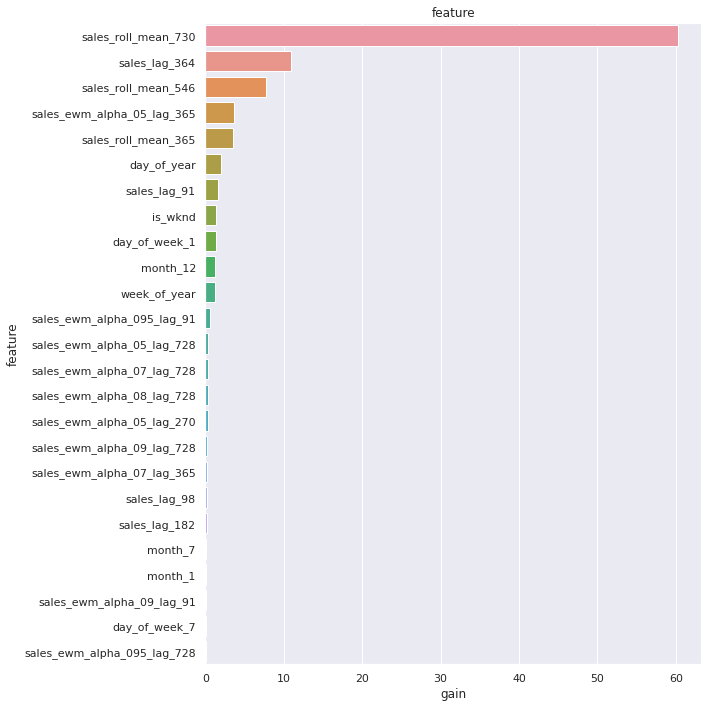

                        feature  split       gain
18          sales_roll_mean_730   4660  60.235744
13                sales_lag_364   5737  10.918246
17          sales_roll_mean_546   4220   7.743150
61   sales_ewm_alpha_05_lag_365   1809   3.666591
16          sales_roll_mean_365   3203   3.521501
1                   day_of_year   5492   2.029423
6                  sales_lag_91   1983   1.635154
3                       is_wknd    893   1.345157
124               day_of_week_1    659   1.313378
142                    month_12   1001   1.201759


In [78]:
plot_lgb_importances(model,30)

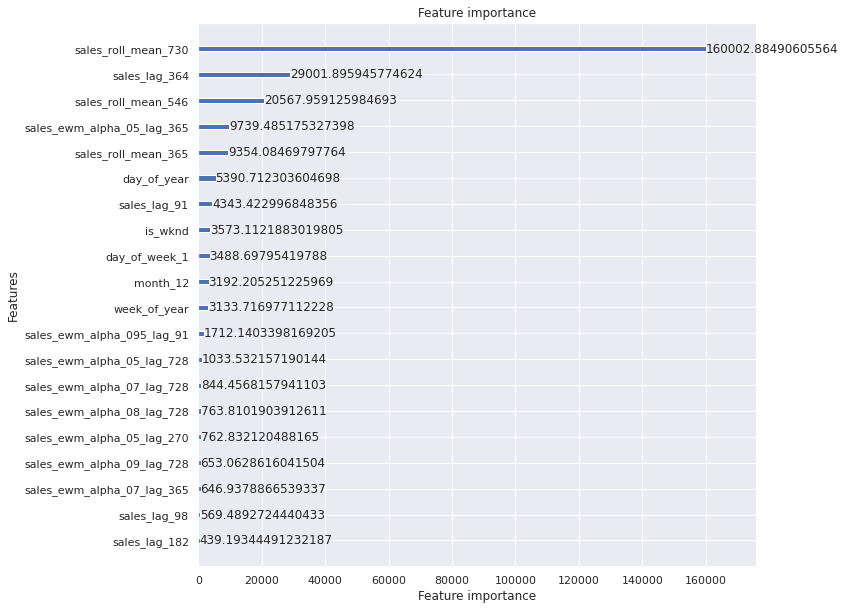

In [79]:
# this one is the built-in plot function of LightGBM library

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

<a id="section-fourteen"></a>
## 3.10.Final Model 

In [80]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [81]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [82]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

<a id="section-fifteen"></a>
## 3.11.Submit Prediction 

In [84]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.to_csv('submission_dps.csv', index=False)